# Prepare the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

# Read in the aggregated dataset
data_agg = pd.read_csv(os.path.join("..", "data", "Final KMPL dataset.csv"))

# Drop the 'REG_NUM' column
data_agg = data_agg.drop('REG_NUM', axis=1)

In [3]:
# Select the columns for clustering
columns_for_clustering = ['Reg', 'KMPL', 'Site Lat', 'Site Long', 
                          'Total Transaction Amount', 'Mean Transaction Amount',
                          'Total No. of Litres', 'Mean No. of Litres']

data_agg_clustering = data_agg[columns_for_clustering]

# Remove rows with missing values
data_agg_clusters = data_agg_clustering.dropna()

# Select the data without the REG_NUM column for the actual clustering
data_agg_clustering = data_agg_clusters.drop('Reg', axis=1)

# Encode the categorical variables
data_agg_encoded = pd.get_dummies(data_agg_clustering)

# Prepare data for clustering (excluding 'REG_NUM' for actual clustering)
X_agg = data_agg_encoded.values

# Standardize the features
scaler_agg = StandardScaler()
X_agg_scaled = scaler_agg.fit_transform(X_agg)

X_agg_scaled.shape

(902, 7)

# k-means clustering

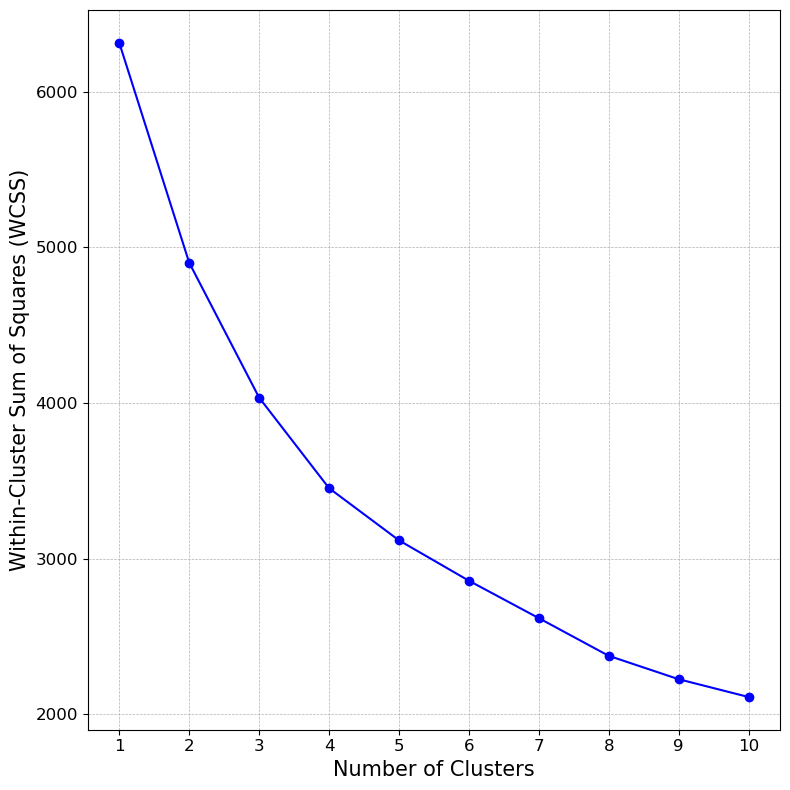

In [4]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_agg_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=15)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../plots/vehicle_clustering/kmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [5]:
# Apply KMeans clustering
kclusts = 4
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_agg_scaled)

# Add cluster labels to the pivot_data DataFrame
data_agg['KmeansCluster'] = kmeans.labels_

# Agglomerative clustering

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute the condensed Euclidean distance matrix
distance_matrix = pdist(X_agg_scaled, metric='euclidean')

# Perform hierarchical clustering using the Ward method
Z_agg = linkage(distance_matrix, metric='ward')

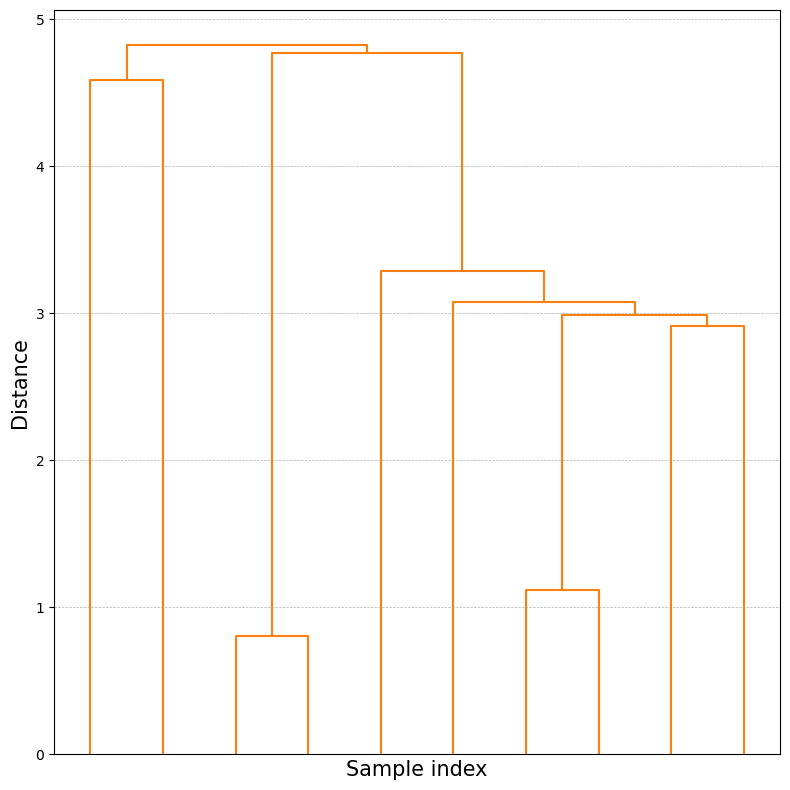

In [8]:
import numpy as np

# Plotting the dendrogram
plt.figure(figsize=(8, 8))
dendrogram(Z_agg, no_labels=True, truncate_mode='level', p=5, color_threshold=np.Inf) # Labels are omitted for clarity
# plt.title('Agglomerative Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample index', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the dendrogram as a PDF file with high resolution
plt.savefig('../plots/vehicle_clustering/agglomerative_dendrogram.pdf', format='pdf', dpi=300)

plt.show()  # Display the dendrogram

In [9]:
# Perform Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=4, metric='euclidean')
clusters = agg_clust.fit_predict(X_agg_scaled)

# Add cluster labels to the DataFrame
data_agg['AggCluster'] = clusters

# Plotting the results

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

def shorten_names(names, max_length=20):
    shortened_names = []
    for name in names:
        if len(name) > max_length:
            shortened_names.append(name[:max_length] + '...')
        else:
            shortened_names.append(name)
    return shortened_names

def stacked_bar_chart_clusters(data, categorical_var, cluster_var, x_title, filename, max_categories=5, max_length=20, color_theme='tab10'):
    # Calculate the proportions of each category in each cluster
    cluster_proportions = data.groupby([cluster_var, categorical_var]).size().unstack(fill_value=0)
    cluster_proportions = cluster_proportions.div(cluster_proportions.sum(axis=1), axis=0)
    
    # Get the top categories and group the rest into "Others"
    top_categories = cluster_proportions.sum().nlargest(max_categories).index
    cluster_proportions["Others"] = cluster_proportions.drop(columns=top_categories).sum(axis=1)
    cluster_proportions = cluster_proportions[top_categories.tolist() + ["Others"]]
    
    # Shorten the category names if necessary
    shortened_names = shorten_names(cluster_proportions.columns, max_length=max_length)
    
    # Check if the cluster labels start from 0 or -1
    if cluster_proportions.index.min() == 0:
        # Shift the cluster labels up by 1 and rename them
        cluster_proportions.index = ["Cluster " + str(i+1) for i in cluster_proportions.index]
    elif cluster_proportions.index.min() == -1:
        # Shift the cluster labels up by 1 (excluding -1) and rename them
        cluster_proportions.index = ["No Cluster" if i == -1 else "Cluster " + str(i+1) for i in cluster_proportions.index]
    
    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set the font size for the labels
    label_font_size = 12
    y_label_font_size = 14
    
    # Get the specified color theme
    color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
    colors = color_scheme(range(len(cluster_proportions.columns)))
    
    # Create the stacked bar chart
    cluster_proportions.plot(kind='bar', stacked=True, ax=ax, legend=False, color=colors)
    
    ax.set_xticklabels(cluster_proportions.index, rotation=0, fontsize=label_font_size)
    ax.set_xlabel(x_title, fontsize=y_label_font_size)
    ax.set_ylabel('Proportion', fontsize=y_label_font_size)
    
    # Create the legend outside the plot
    ax.legend(title='Categories', fontsize=label_font_size, labels=shortened_names, 
              loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Adjust the spacing
    plt.tight_layout()
    
    # Save the plot as a PDF file
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    # Close the plot
    plt.close(fig)


def four_stacked_plots(data, categorical_vars, cluster_var, titles, filename, max_categories=8, max_length=20, color_theme='tab10'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.ravel()

    for i, (cat_var, title) in enumerate(zip(categorical_vars, titles)):
        # Calculate the proportions of each category in each cluster
        cluster_proportions = data.groupby([cluster_var, cat_var]).size().unstack(fill_value=0)
        cluster_proportions = cluster_proportions.div(cluster_proportions.sum(axis=1), axis=0)

        # Get the top categories and group the rest into "Others"
        top_categories = cluster_proportions.sum().nlargest(max_categories).index
        cluster_proportions["Others"] = cluster_proportions.drop(columns=top_categories).sum(axis=1)
        cluster_proportions = cluster_proportions[top_categories.tolist() + ["Others"]]

        # Shorten the category names if necessary
        shortened_names = shorten_names(cluster_proportions.columns, max_length=max_length)

        # Check if the cluster labels start from 0 or -1
        if cluster_proportions.index.min() == 0:
            # Shift the cluster labels up by 1 and rename them
            cluster_proportions.index = [str(i+1) for i in cluster_proportions.index]
        elif cluster_proportions.index.min() == -1:
            # Shift the cluster labels up by 1 (excluding -1) and rename them
            cluster_proportions.index = ["None" if i == -1 else str(i+1) for i in cluster_proportions.index]

        # Get the specified color theme
        color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
        colors = color_scheme(range(len(cluster_proportions.columns)))

        # Create the stacked bar chart in the corresponding subplot
        cluster_proportions.plot(kind='bar', stacked=True, ax=axs[i], legend=False, color=colors)

        axs[i].set_xticklabels(cluster_proportions.index, rotation=0, fontsize=12)
        axs[i].set_xlabel('Cluster', fontsize=14)
        axs[i].set_ylabel('Proportion', fontsize=14)
        axs[i].set_title(f"{chr(97+i)}) {title}")  # Prepend "a) ", "b) ", "c) ", "d) " to the titles

        # Create the legend for each subplot
        axs[i].legend(title='Categories', fontsize=10, labels=shortened_names, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close(fig)

In [20]:
data_agg.columns

Index(['Reg', 'Overlap_Start', 'Overlap_End', 'Total_Km', 'Total_Litres',
       'KMPL', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT', 'District',
       'Site', 'Site Lat', 'Site Long', 'Fuel Type', 'RATE CARD CATEGORY',
       'Total Transaction Amount', 'Mean Transaction Amount',
       'Total No. of Litres', 'Mean No. of Litres', 'KmeansCluster',
       'AggCluster'],
      dtype='object')

In [48]:
stacked_bar_chart_clusters(data_agg, 'MODEL DERIVATIVE', 'AggCluster', 'Cluster', 
                           '../plots/vehicle_clustering/agg_clustered_vehicle_model.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'DEPARTMENT', 'AggCluster', 'Cluster', 
                           '../plots/vehicle_clustering/agg_clustered_vehicle_department.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'District', 'AggCluster', 'Cluster', 
                           '../plots/vehicle_clustering/agg_clustered_vehicle_district.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'RATE CARD CATEGORY', 'AggCluster', 'Cluster', 
                           '../plots/vehicle_clustering/agg_clustered_vehicle_category.pdf',
                           max_categories=8, max_length=20)

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[na

In [88]:
four_stacked_plots(data_agg,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'AggCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/vehicle_clustering/agg_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15)

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/861687369.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/861687369.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/861687369.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[na

In [49]:
stacked_bar_chart_clusters(data_agg, 'MODEL DERIVATIVE', 'KmeansCluster', 'Cluster', 
                           '../plots/vehicle_clustering/kmeans_clustered_vehicle_model.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'DEPARTMENT', 'KmeansCluster', 'Cluster', 
                           '../plots/vehicle_clustering/kmeans_clustered_vehicle_department.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'District', 'KmeansCluster', 'Cluster', 
                           '../plots/vehicle_clustering/kmeans_clustered_vehicle_district.pdf',
                           max_categories=8, max_length=20)

stacked_bar_chart_clusters(data_agg, 'RATE CARD CATEGORY', 'KmeansCluster', 'Cluster', 
                           '../plots/vehicle_clustering/kmeans_clustered_vehicle_category.pdf',
                           max_categories=8, max_length=20)

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_80566/335774383.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[na